INF6804<br>
Polytechnique Montréal<br>
TP3: Détection et suivi de multiples objets d'intérêt<br>

Auteurs:<br>
Marc-Olivier Bélanger - 1840713<br>
Pierre-Luc Chartier - 1805679

### Déclarations globales

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import scipy.optimize as sci
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request as request

In [3]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
    COCO_NAMES.append(label_name.strip().decode('UTF-8'))

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.95

source_path = "/Users/mabelal/Downloads/TP3_data/frames"

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

In [4]:
# taken from https://answers.opencv.org/question/90455/how-to-perform-intersection-or-union-operations-on-a-rect-in-python/
def intersection_area(a, b):
    x_min = max(a[0], b[0])
    y_min = max(a[1], b[1])
    x_max = min(a[2], b[2])
    y_max = min(a[3], b[3])
    
    width = x_max - x_min
    height = y_max - y_min
    
    if width < 0 or height < 0:
        return 0
    
    return width*height


def union_area(a, b):
    w_a = a[2] - a[0]
    h_a = a[3] - a[1]
    
    w_b = b[2] - b[0]
    h_b = b[3] - b[1]
    
    area_a = w_a * h_a
    area_b = w_b * h_b
    
    return area_a + area_b - intersection_area(a, b)


def intersection_over_union(a, b):
    return intersection_area(a, b) / union_area(a, b)

### Détection des objets (Mask R-CNN)

In [12]:
def detect_objects(img):
    preprocess = transforms.Compose([transforms.ToTensor()])
    tensors = [preprocess(img)]
    
    predictions = model(tensors)
    boxes = []
    
    for p in predictions:
        for j, score in enumerate(p['scores']):
            if score >= SCORE_THRESHOLD:
                label = p['labels'][j]
                is_cup_or_person = (COCO_NAMES[label] == "cup") #or (COCO_NAMES[label] == "person")

                if is_cup_or_person:
                    boxes.append(p['boxes'][j].detach().numpy())
    return boxes

### Description des objets (Histogramme de couleurs)

In [6]:
def calc_color_hist(img, bbox):
    roi = (bbox[0], bbox[1], bbox[2], bbox[3])
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([img],[0],mask,[64],[0,256])


def compare_color_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

### Association des données (Mean-Shift et algorithme hongrois)

In [7]:
def calc_cost_matrix(tracked_objects, current_img, current_bboxes):
    cost_matrix = np.zeros((len(tracked_objects), len(current_bboxes)))
    for i in range(0,len(tracked_objects)):
        for j in range(0,len(current_bboxes)):
            hist_current = calc_color_hist(current_img, current_bboxes[j])
            cost_matrix[i,j] = compare_color_hist(tracked_objects[i].histogram, hist_current)
    return cost_matrix


def mean_shift(tracked_obj, current_img):           
    retro = cv2.calcBackProject([current_img], [0], tracked_obj.histogram, [0,64], 1)

    end_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    
    to_box = tracked_obj.box()    
    iterations, box = cv2.meanShift(retro, (to_box[0], to_box[1], to_box[2]-to_box[0], to_box[3]-to_box[1]), end_crit)
    x_min, y_min, width, height = box
    
    return x_min, y_min, x_min+width, y_min+height

        
def associate_data(tracked_objects, current_img, current_bboxes):    
    cost_matrix = calc_cost_matrix(tracked_objects, current_img, current_bboxes)
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    
    for i in range(0, len(row_ind)):
        # check if association from hungarian algorithm makes sense based on IOU
        iou_score = intersection_over_union(tracked_objects[row_ind[i]].box(), current_bboxes[col_ind[i]])
        if iou_score > IOU_THRESHOLD:
            # model detected object, update it with its predicted bbox and update its description
            tracked_objects[row_ind[i]].was_detected = True
            x_min, y_min, x_max, y_max = current_bboxes[col_ind[i]]
            tracked_objects[row_ind[i]].update(x_min, y_min, x_max, y_max)
            tracked_objects[row_ind[i]].histogram = calc_color_hist(current_img, tracked_objects[row_ind[i]].box())
    
    # apply mean-shift to tracked objects that were not detected by the model
    # update to predicted box if IOU > threshold
    for ob in tracked_objects.values():
        if not ob.was_detected:
            x_min, y_min, x_max, y_max = mean_shift(ob, current_img)
            
            iou_score = intersection_over_union(ob.box(), (x_min, y_min, x_max, y_max))
            if iou_score > IOU_THRESHOLD:
                ob.update(x_min, y_min, x_max, y_max)
        else:
            # reset for next frame
            ob.was_detected = False          
            
    return row_ind, col_ind

### Algorithme principal

In [8]:
class TrackedObject:
    def __init__(self, object_id, x_min, y_min, x_max, y_max):
        self.object_id = object_id
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.was_detected = False
        self.histogram = None
    
    
    def update(self, x_min, y_min, x_max, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
            
    
    def box(self):
        return self.x_min, self.y_min, self.x_max, self.y_max
    
    
    def __str__(self):
        ws = " "
        return ws.join([str(self.object_id+1), str(round(self.x_min)),
                        str(round(self.x_max)), str(round(self.y_min)), str(round(self.y_max))])

In [9]:
def algo(path_to_frames, tracked_objects, result_file):
    # some magic to get the frames in the right order
    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)
    frames = sorted(frames, key = lambda s : len(s))
    
    # initial frame
    prev_img = cv2.imread(os.path.join(path_to_frames, frames[0]), cv2.IMREAD_GRAYSCALE)
    for ob in tracked_objects.values():
        ob.histogram = calc_color_hist(prev_img, ob.box())
    
    f = open(result_file, "w+")
    for i in range(0, len(tracked_objects)):
        f.write("1 " + str(tracked_objects[i]) + "\n")
    
    # main loop
    for i in range(1, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        associate_data(tracked_objects, img, boxes)
        
        for j in range(0, len(tracked_objects)):
            f.write(str(i+1) + " " + str(tracked_objects[j]) + "\n")
        
        prev_img = img
        
        if (i % 5) == 0:
            print("Progress: " + frames[i])
    
    f.close()

In [10]:
def algo_mot():
    return None

### Test de l'association des données

1 588 799 363 577
2 1062 1441 555 981


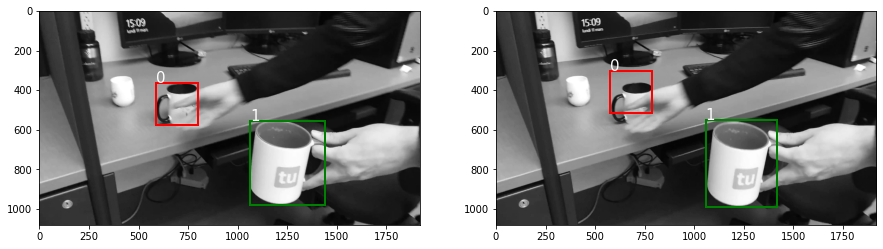

1 574 785 302 516
2 1058 1420 549 991


In [13]:
### Test association des données ###

img = cv2.imread(os.path.join(source_path, "frame124.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1 = TrackedObject(0, 588, 363, 799, 577)
cup_2 = TrackedObject(1, 1062, 555, 1441, 981)

# modelisation des objets a partir de la premiere image
first_img = cv2.imread(os.path.join(source_path, "frame1.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1.histogram = calc_color_hist(first_img, cup_1.box())
cup_2.histogram = calc_color_hist(first_img, cup_2.box())

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

img2 = cv2.imread(os.path.join(source_path, "frame125.jpg"), cv2.IMREAD_GRAYSCALE)
b2 = detect_objects(img2)

fig, axarr = plt.subplots(1, 2, figsize=(15,15))
bboxcolor = 'rgbcmy'

axarr[0].imshow(img, cmap = plt.cm.gray)
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[0].add_patch(rect)
    axarr[0].text(b[0], b[1], i, color='white', fontsize=15)

for to in tracked_objects.values():
    print(to)

row_ind, col_ind = associate_data(tracked_objects, img2, b2)
#print(row_ind)
#print(col_ind)

axarr[1].imshow(img2, cmap = plt.cm.gray)
#for i, b in enumerate(b2):
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    rect = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor=bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    axarr[1].text(b[0], b[1], i, color='white', fontsize=15)
    
plt.show()

for to in tracked_objects.values():
    print(to)

############

### MOT17-11: Forward moving camera in a busy shopping mall

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

# will need to create tracked_objects or smtg
# call algo, print in results file, then use the file to compute MOTA

### MOT17-05: Street scene from a moving platform

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

### MOT17-13 : Filmed from a bus on a busy intersection

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

### Résultats sur les trames fournies

In [ ]:
# init.txt
cup_1 = TrackedObject(0, 830, 474, 1112, 755)
cup_2 = TrackedObject(1, 1194, 433, 1479, 700)

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

algo("/Users/mabelal/Downloads/TP3_data/frames", tracked_objects, "result_cups.txt")

Progress: frame6.jpg
Progress: frame11.jpg
Progress: frame16.jpg
Progress: frame21.jpg
Progress: frame26.jpg
Progress: frame31.jpg
Progress: frame36.jpg
Progress: frame41.jpg


### Validation des résultats

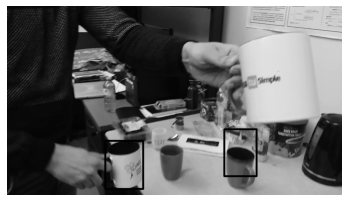

frame701.jpg
701 1 563 780 770 1045

701 2 1245 1430 704 972



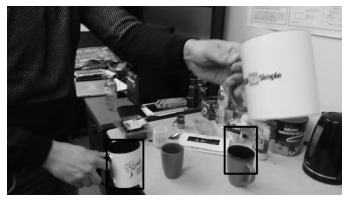

frame702.jpg
702 1 571 781 764 1045

702 2 1247 1432 690 958



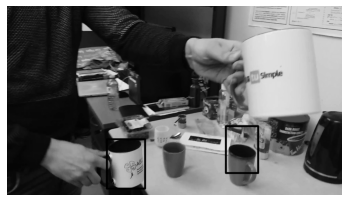

frame703.jpg
703 1 572 791 761 1043

703 2 1254 1439 686 954



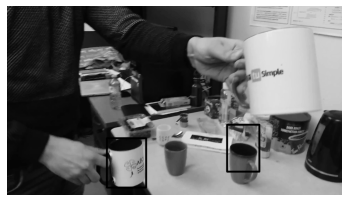

frame704.jpg
704 1 572 797 755 1037

704 2 1261 1446 678 946



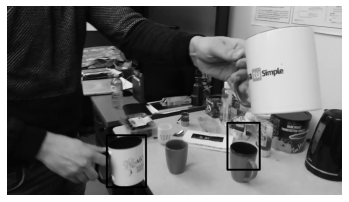

frame705.jpg
705 1 572 796 738 1035

705 2 1263 1448 667 935



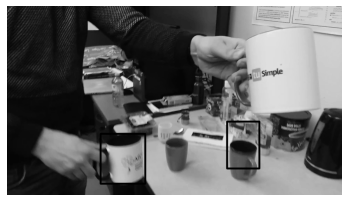

frame706.jpg
706 1 536 792 730 1015

706 2 1261 1446 660 928



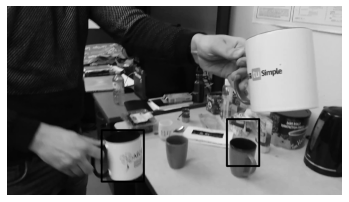

frame707.jpg
707 1 542 784 709 1003

707 2 1260 1445 646 914



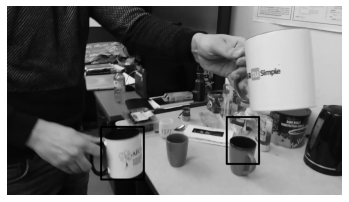

frame708.jpg
708 1 539 784 690 991

708 2 1259 1444 634 902



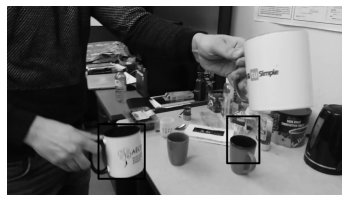

frame709.jpg
709 1 524 789 675 987

709 2 1261 1446 630 898



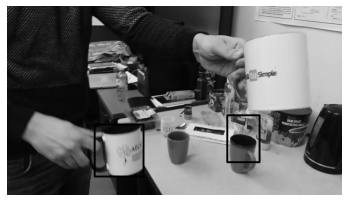

frame710.jpg
710 1 502 782 677 974

710 2 1262 1447 624 892



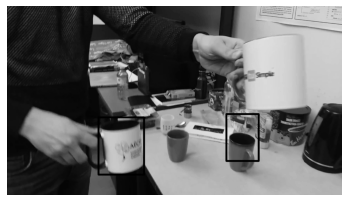

frame711.jpg
711 1 524 785 636 963

711 2 1257 1442 617 885



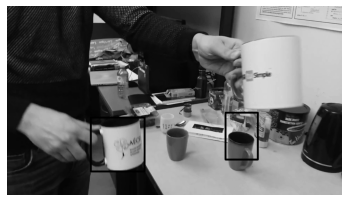

frame712.jpg
712 1 480 788 637 945

712 2 1252 1437 609 877



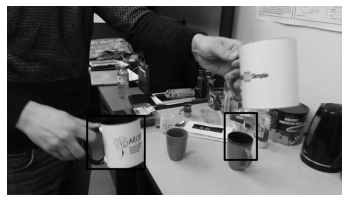

frame713.jpg
713 1 459 789 627 931

713 2 1247 1432 611 879



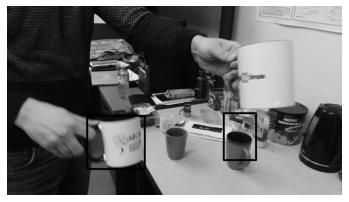

frame714.jpg
714 1 459 789 627 931

714 2 1242 1427 612 880



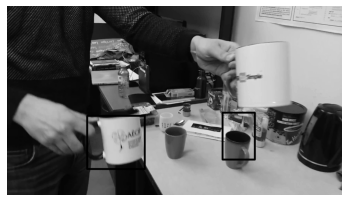

frame715.jpg
715 1 459 789 627 931

715 2 1235 1420 609 877



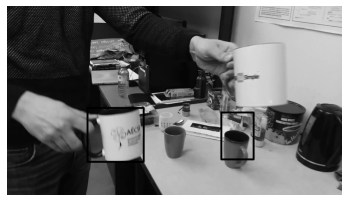

frame716.jpg
716 1 461 783 582 890

716 2 1228 1413 608 876



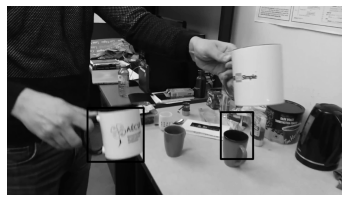

frame717.jpg
717 1 461 783 582 890

717 2 1225 1410 606 874



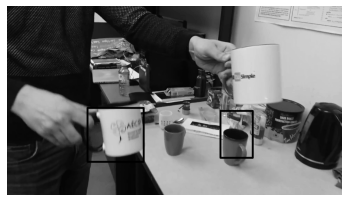

frame718.jpg
718 1 461 783 582 890

718 2 1223 1408 599 867



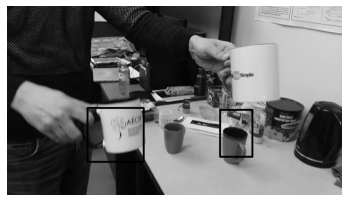

frame719.jpg
719 1 461 783 582 890

719 2 1221 1406 593 861



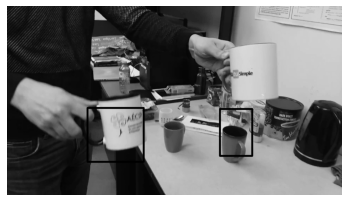

frame720.jpg
720 1 461 783 582 890

720 2 1220 1405 588 856



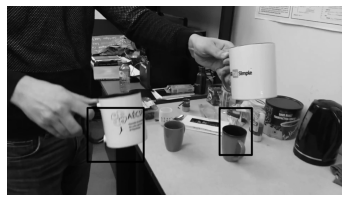

frame721.jpg
721 1 461 783 582 890

721 2 1218 1403 583 851



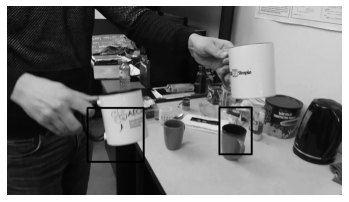

frame722.jpg
722 1 461 783 582 890

722 2 1217 1402 579 847



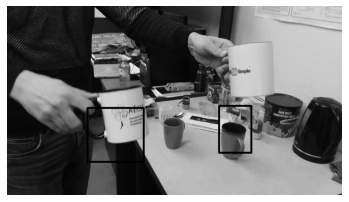

frame723.jpg
723 1 461 783 582 890

723 2 1215 1400 570 838



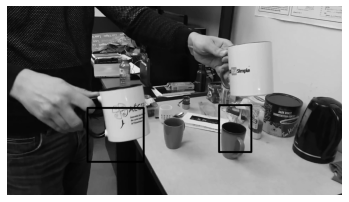

frame724.jpg
724 1 461 783 582 890

724 2 1215 1400 566 834



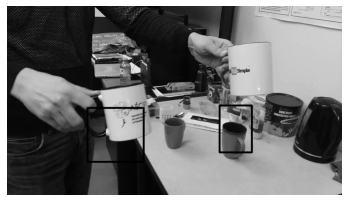

frame725.jpg
725 1 461 783 582 890

725 2 1218 1403 568 836



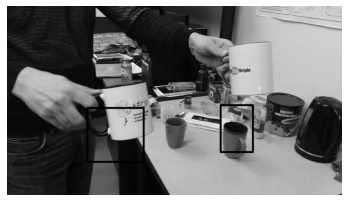

frame726.jpg
726 1 461 783 582 890

726 2 1224 1409 566 834



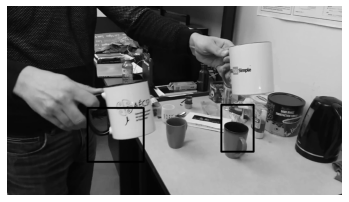

frame727.jpg
727 1 461 783 582 890

727 2 1228 1413 564 832



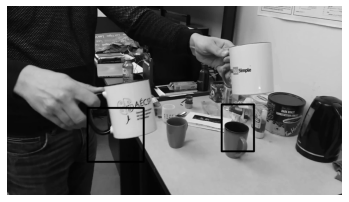

frame728.jpg
728 1 461 783 582 890

728 2 1230 1415 562 830



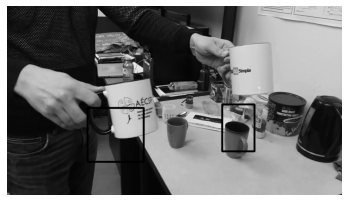

frame729.jpg
729 1 461 783 582 890

729 2 1233 1418 562 830



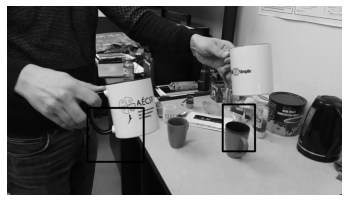

frame730.jpg
730 1 461 783 582 890

730 2 1236 1421 562 830



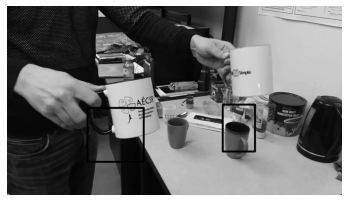

frame731.jpg
731 1 461 783 582 890

731 2 1236 1421 563 831



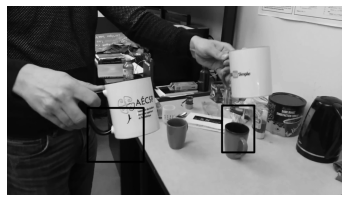

frame732.jpg
732 1 461 783 582 890

732 2 1232 1417 568 836



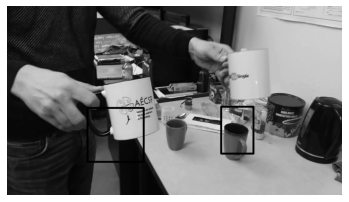

frame733.jpg
733 1 461 783 582 890

733 2 1227 1412 575 843



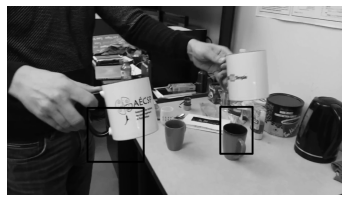

frame734.jpg
734 1 461 783 582 890

734 2 1222 1407 576 844



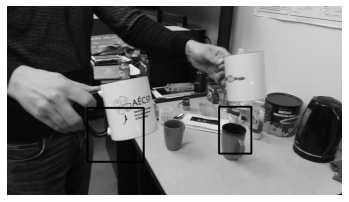

frame735.jpg
735 1 461 783 582 890

735 2 1215 1400 575 843



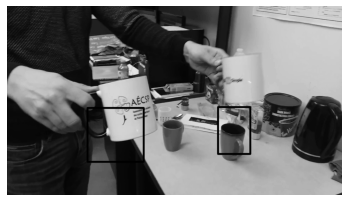

frame736.jpg
736 1 461 783 582 890

736 2 1209 1394 577 845



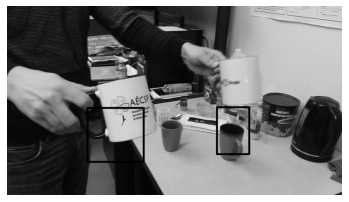

frame737.jpg
737 1 461 783 582 890

737 2 1203 1388 578 846



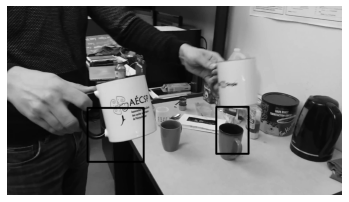

frame738.jpg
738 1 461 783 582 890

738 2 1199 1384 576 844



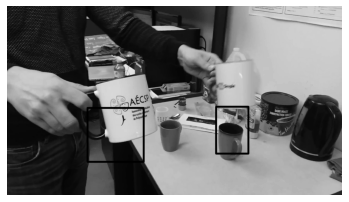

frame739.jpg
739 1 461 783 582 890

739 2 1198 1383 575 843



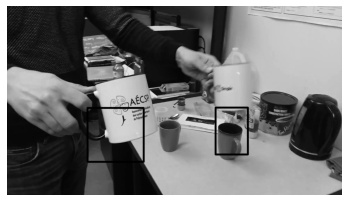

frame740.jpg
740 1 461 783 582 890

740 2 1195 1380 580 848



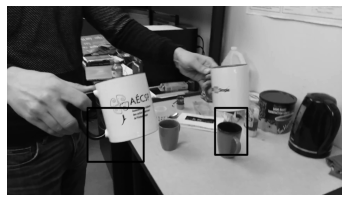

frame741.jpg
741 1 461 783 582 890

741 2 1192 1377 582 850



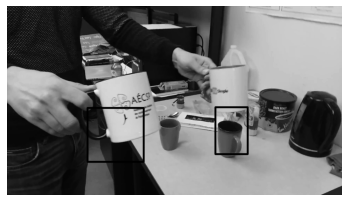

frame742.jpg
742 1 461 783 582 890

742 2 1194 1379 578 846



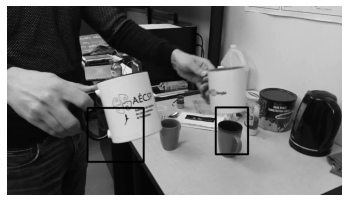

frame743.jpg
743 1 461 783 582 890

743 2 1196 1381 579 847



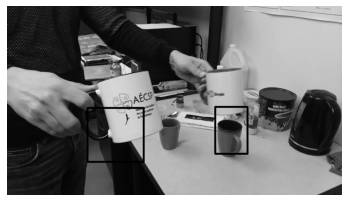

frame744.jpg
744 1 461 783 582 890

744 2 1193 1378 576 844



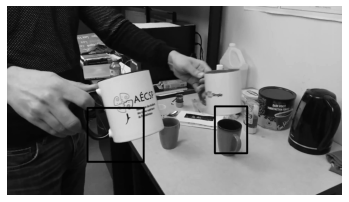

frame745.jpg
745 1 461 783 582 890

745 2 1191 1376 573 841



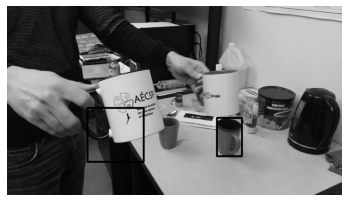

frame746.jpg
746 1 461 783 582 890

746 2 1203 1346 639 858



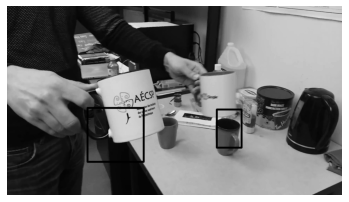

frame747.jpg
747 1 461 783 582 890

747 2 1202 1344 591 809



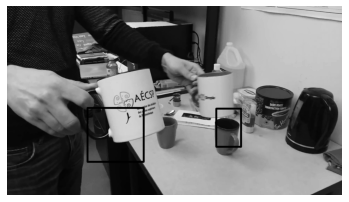

frame748.jpg
748 1 461 783 582 890

748 2 1199 1341 586 804



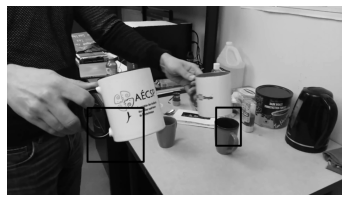

frame749.jpg
749 1 461 783 582 890

749 2 1198 1340 580 798



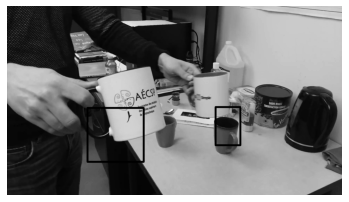

frame750.jpg
750 1 461 783 582 890

750 2 1195 1337 577 795



In [145]:
### Validation des résultats

f = open("result_cups.txt", "r")
lines = f.readlines()
f.close()

frames = [name for name in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, name))]
frames = sorted(frames)
frames = sorted(frames, key = lambda s : len(s))

i = 701
for j in range (0, 50):
    img = cv2.imread(os.path.join(source_path, frames[i-1+j]), cv2.IMREAD_GRAYSCALE)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))+1].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis("off")
    plt.show()
    
    print(frames[i-1+j])
    print(lines[(2*(i-1+j))])
    print(lines[(2*(i-1+j))+1])
